# This notebook is for Analyzing Enron Email Dataset

## Tasks to Do

1. Select emails base on keywords 
    1. Load, Clean & Parse Emails to get started
    2. Select emails based on keywords
2. Time series analysis of the emails
    1. Parse string to Datetime object for doing time series analysis
    2. Plot time series
3. Email Clustering
    1. Rremoving stopwords and vectorize the content
    2. Run KMeans on the Data
    3. Find important keywords from for each clusters
    4. Find topics from the text (??)
4. Sentiment Analysis
    1. Do Sentiment analysis on the email texts
    2. plot sentiments 


#### Importing modules

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans, MiniBatchKMeans
import re

%load_ext autoreload
%autoreload 2

from parse_utils import parse_raw_message, parse_into_emails
from plot_utils import top_mean_feats, top_feats_per_cluster, plot_tfidf_classfeats_h
plt.rcParams["figure.figsize"] = (20,8) #Setting global parameters for plots


#### Reading Data from the directory

In [2]:
df = pd.read_csv('enron_email/emails.csv')


#### Select Emails those have the word project

In [3]:
def mark_words(row):
    if 'project' in row['message']:
        return 'has project word'
    return 'no project word'

df['project_status'] = df.apply(mark_words, axis = 1)

In [4]:
project_df = df[df['project_status'] == 'has project word']

#### A simple email data

In [5]:
project_df['message'].tolist()[:5]

["Message-ID: <13116875.1075855687561.JavaMail.evans@thyme>\nDate: Mon, 9 Oct 2000 07:16:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: keith.holst@enron.com\nSubject: Consolidated positions: Issues & To Do list\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Keith Holst\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Dec2000\\Notes Folders\\'sent mail\nX-Origin: Allen-P\nX-FileName: pallen.nsf\n\n---------------------- Forwarded by Phillip K Allen/HOU/ECT on 10/09/2000 \n02:16 PM ---------------------------\n\n\nRichard Burchfield\n10/06/2000 06:59 AM\nTo: Phillip K Allen/HOU/ECT@ECT\ncc: Beth Perlman/HOU/ECT@ECT \nSubject: Consolidated positions: Issues & To Do list\n\nPhillip,\n Below is the issues & to do list as we go forward with documenting the \nrequirements for consolidated physical/financial positions and transport \ntrade capture. What we need to focus on is the first bullet in Allan's list; \nth

In [6]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to', 'subject', 'date', 'x-from', 'x-to']
    subject_found = False
    for line in lines:
        
        if ':' not in line:
            if not subject_found:
                continue
            message += line.strip() + ' '
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
            if key in ['subject', 'to', 'cc']:
                subject_found = True
    if 'body' in email.keys():
        email['body'] = re.sub(r'([,?.])', r' \1 ', email['body'])  #Use regex for more punctuation to do at once
        email['body'] = email['body'].lower()
        email['body'] = re.sub(' +', ' ', email['body'])
        email['body'] = email['body'].strip()
    return email
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
        
    bodies = []
    tos = []
    froms = []
    subjects = []
    dates = []
    xfroms = []
    xtos = []
    for email in emails:
        froms.append(email['from'])
        tos.append(email.get('to', None))
        bodies.append(email.get('body', None))
        subjects.append(email.get('subject', None))
        dates.append(email.get('date', None))
        xfroms.append(email.get('x-from', None))
        xtos.append(email.get('x-to', None))
    return {
        'body': bodies, 
        'to': tos, 
        'from_': froms,
        'subject': subjects,
        'date': dates,
        'xfroms': xfroms,
        'xtos': xtos
    }

#### Parsing Emails for extracting important information. For example( Sender, Reciever, Subject, Body, Date, etc.)

#### Simple Parsed Email

In [7]:
parsed_email = parse_raw_message(project_df['message'].tolist()[5])

for key, val in parsed_email.items():
    print(key, ' : ', val)
    

date  :  Wed, 20 Sep 2000 06
from  :  phillip.allen@enron.com
to  :  cbpres@austin.rr.com
subject  :  
x-from  :  Phillip K Allen
x-to  :  cbpres@austin.rr.com
body  :  george , below is a list of questions that keith and i had regarding the westgate ownership structure what will be the ownership structure ? limited partnership ? general partner ? what are all the legal entities that will be involved and in what capacity(regarding ownership and liabilities) ? who owns the land ? improvements ? who holds the various loans ? is the land collateral ? investment what happens to initial investment ? is it used to purchase land for cash ? secure future loans ? why is the land cost spread out on the cash flow statement ? when is the 700 , 000 actually needed ? now or for the land closing ? investment schedule ? investment return is equity repayment the return of the original investment ? is the plan to wait until the last unit is sold and closed before profits are distributed ? debt which ent

In [8]:
project_email_df = pd.DataFrame(parse_into_emails(project_df.message))
print('Total Emails containg word project ', len(project_email_df))

Total Emails containg word project  27187


#### Clean Duplicate Body Emails

In [9]:
project_email_df = project_email_df.drop_duplicates(['body'],keep = 'first')
print('Total Unique Emails containging word project ', len(project_email_df))

Total Unique Emails containging word project  12073


#### Word Frequency of emails

Text(0, 0.5, 'Count')

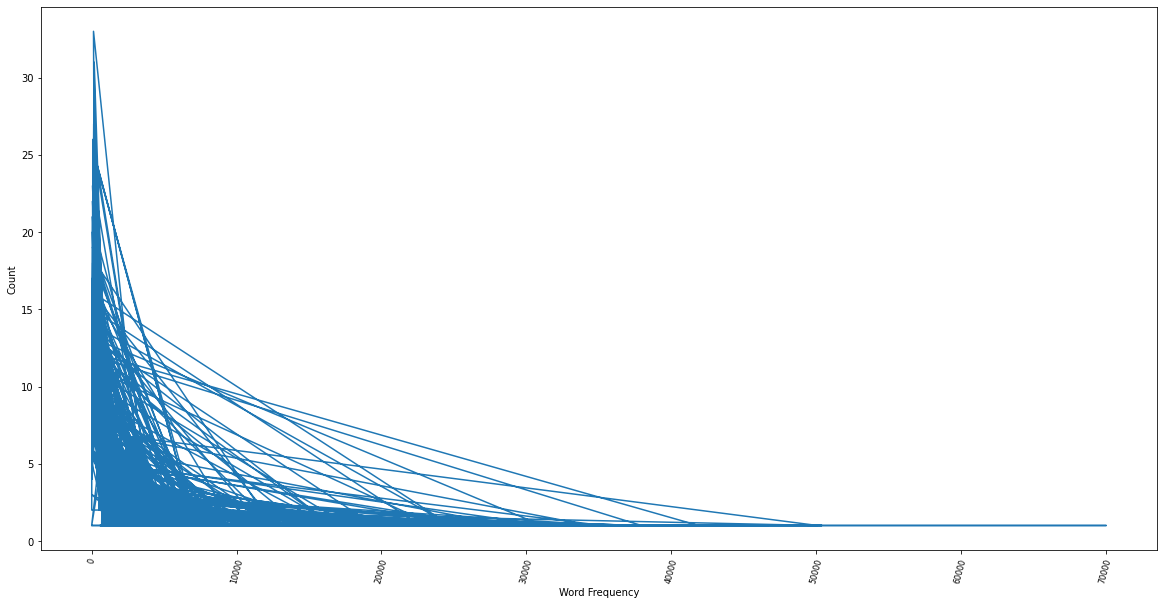

In [10]:
word_freq = {}
frequencies = []

for body in project_email_df['body'].tolist():
    try:
        words_in_this_body = list(filter(None, body.split(' ')))
    except:
        continue
    word_count = len(words_in_this_body)
    word_freq[word_count] = word_freq.get(word_count, 0) + 1
    frequencies.append(word_count)


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.plot(word_freq.keys(), word_freq.values() )

plt.xlabel('Word Frequency')
plt.ylabel('Count')



Text(0, 0.5, 'Count')

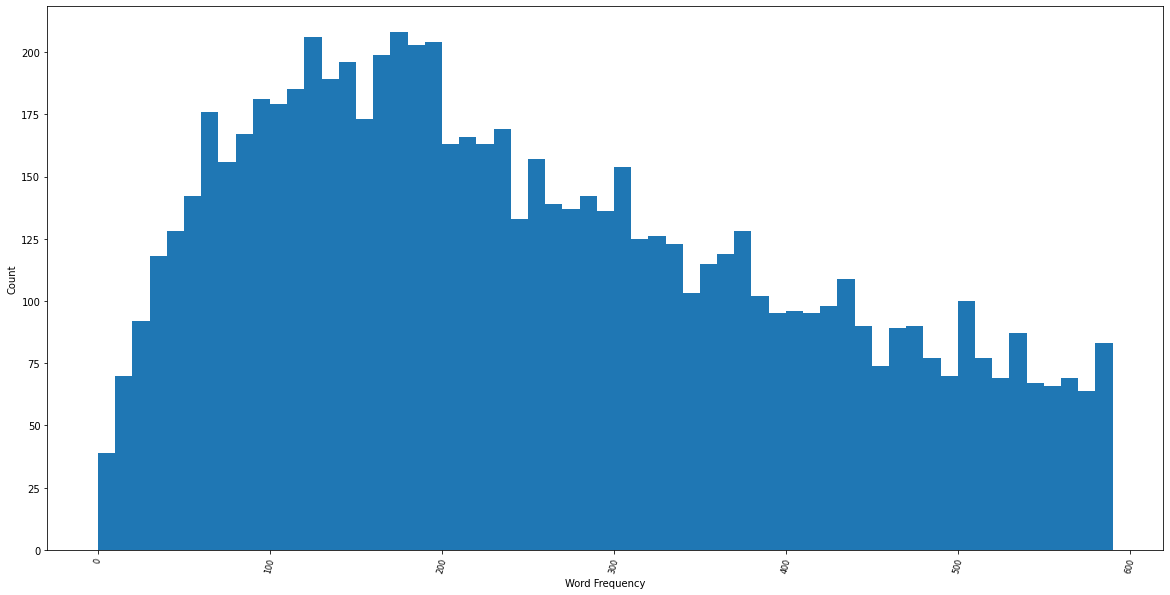

In [11]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.xticks(rotation=75, fontsize=8)
ax.hist(frequencies, bins=range(0, 600, 10)) # Change the bin 1st two parameters two distribute between two ranges, thrid parameter is fo difference

plt.xlabel('Word Frequency')
plt.ylabel('Count')

#### Checked Important Email Senders

In [12]:
largest_emails = project_email_df.groupby('from_').size().nlargest(5)

<AxesSubplot:xlabel='from_'>

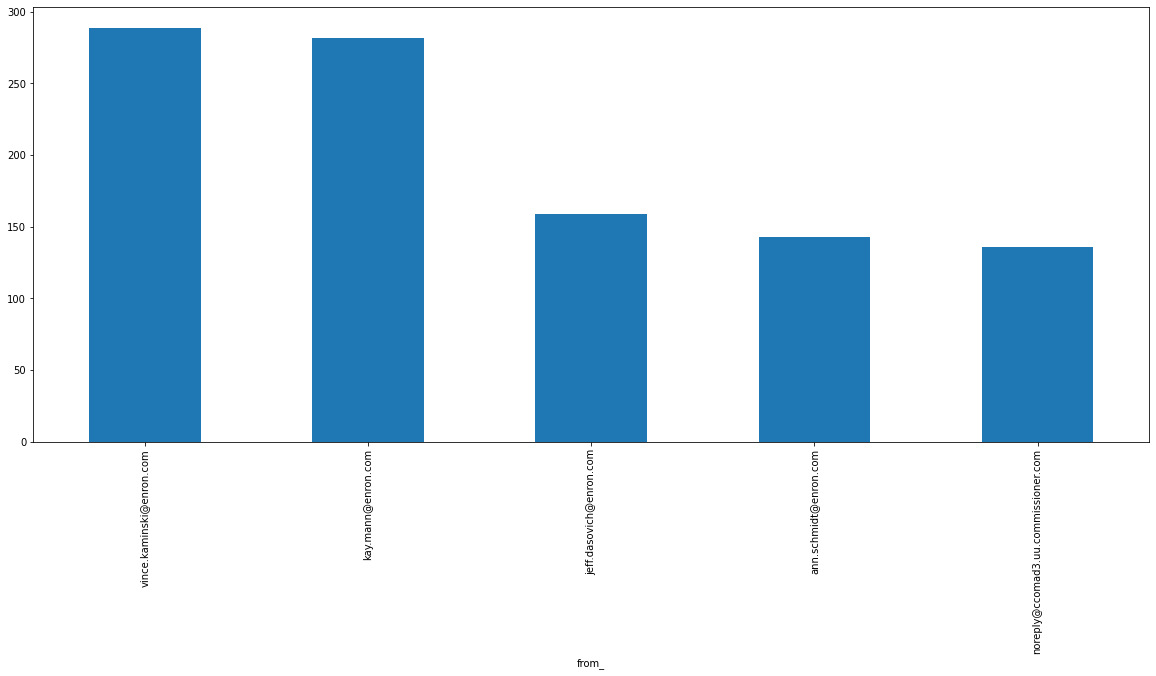

In [13]:
largest_emails.plot.bar()

In [14]:
project_email_df.to_csv('processed_data/parsed_emails.csv', index = False)